# Scikit-Learn Pipelines

This is a general test of the Pipeline API in Scikit-learn.

Goal: Determine if using pipelines is a significant improvement moving forward for us to work with Scikit-learn.

Expected outcome: Pipelines will allow us to make robust functionality to preprocess datasets before using Pycaret or to even predict with it.

Result: They kind of don't work for us? Depends. If you Don't add any extra columns then it'll work, but if you do add extra columns it'll be janky. Realistically, i think just using a function that applys transforms and returns a Dataframe is a better answer, unfortunately.
* Only thing is with the function method, is you can't use gridsearch if you want to do any hyperparameter tuning.

General Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
# from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
def print_scores(y_test, predictions):
    print(f"MAE: {mean_absolute_error(y_test, predictions)}")
    print(f"F1: {f1_score(y_test, predictions, average=None)}")
    print(f"F1: {f1_score(y_test, predictions, average='weighted')}")
    print(f"Accuracy: {accuracy_score(y_test, predictions)}")

In [4]:
CLUSTER = "prod-app"
DATABASE = "stlrcanucks"
LKUPCLIENTID = "7"
SCORING_YEAR = 2022
PRODUCT_MAPPING = {'Mini Pack': 0, 'Quarter': 1, 'Half Season': 2, 'Full Season': 3}
PRODUCT_CURRENT_MAPPING = {'Individual': 0, 'Group': 1, 'Mini Pack': 2, 'Quarter': 3, 'Half Season': 4, 'Full Season': 5}


In [5]:
dataset = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=0
)

dataset.shape

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


(699126, 27)

In [291]:
df = dataset.copy()

In [292]:
features = [
    "atp_last",
    "attended_last",
    "distance",
    "events_last",
    "spend_current",
    "sends",
    "tenure",
    "opens",
    "product",
    "product_current",
    "volume_current"
]

df = df[features]

In [293]:
product_plans = [
   "Full Season",
   "Half Season",
   "Quarter",
   "Mini Pack"
]

In [294]:
df = df[df["product"].isin(product_plans)].reset_index(drop=True)
df.shape

(15924, 11)

In [295]:
df = df.replace("None", np.nan)
df = df.fillna(value=np.nan)

In [296]:
df["product"].value_counts()

Full Season    10186
Quarter         3526
Half Season     1778
Mini Pack        434
Name: product, dtype: int64

In [297]:
df.describe()

,atp_last,attended_last,distance,events_last,spend_current,sends,tenure,opens,volume_current
count,13323.000000,13323.000000,15924.000000,13323.000000,1.592400e+04,15607.000000,15924.000000,15607.000000,15924.000000
mean,113.425459,26.010733,66.315119,30.412745,1.147543e+04,46.355482,2.969731,67.283463,98.396697
std,63.077590,16.651856,319.442262,18.038207,6.479036e+04,24.670630,1.623274,79.022914,717.966317
min,0.000000,0.000000,0.390000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000
25%,66.575000,10.000000,5.270000,11.000000,2.956800e+03,34.000000,2.000000,17.000000,29.000000
50%,120.230000,33.000000,12.600000,44.000000,8.491600e+03,46.000000,3.000000,52.000000,88.000000
75%,152.250000,41.000000,33.600000,45.000000,1.397285e+04,62.000000,4.000000,91.000000,90.000000
max,517.990000,45.000000,4491.640000,45.000000,4.684388e+06,140.000000,6.000000,1461.000000,52140.000000


In [298]:
df.isna().sum()

atp_last           2601
attended_last      2601
distance              0
events_last        2601
spend_current         0
sends               317
tenure                0
opens               317
product               0
product_current    6245
volume_current        0
dtype: int64

In [299]:
X = df.drop("product", axis=1)
df["product_encoded"] = LabelEncoder().fit_transform(df["product"])
y = df["product_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                random_state=1121218)

In [300]:
df[["product_encoded", "product"]].value_counts()

product_encoded  product    
0                Full Season    10186
3                Quarter         3526
1                Half Season     1778
2                Mini Pack        434
dtype: int64

In [301]:
rf_test = RandomForestClassifier()


df_test = df.copy()
df_test = df_test.dropna()

X = df_test.drop(["product", "product_current"], axis=1)
X.drop("product_encoded", inplace=True, axis=1)
df_test["product_encoded"] = LabelEncoder().fit_transform(df_test["product"])
y = df_test["product_encoded"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=.3, 
                                                random_state=1121218)

rf_test.fit(X_train_t, y_train_t)
score = rf_test.score(X_test_t, y_test_t)
print(f"Accuracy: {score}")
pred = rf_test.predict(X_test_t)
print_scores(pred, y_test_t)

Accuracy: 0.9053763440860215
MAE: 0.16487455197132617
F1: [0.96191457 0.70629371 0.38888889 0.84      ]
F1: 0.9080227786928766
Accuracy: 0.9053763440860215


In [302]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 9 numerical features: 

['atp_last', 'attended_last', 'distance', 'events_last', 'spend_current', 'sends', 'tenure', 'opens', 'volume_current']


In [303]:
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

# if "product" not in categorical_features:
#     categorical_features.append("product")

There are 1 categorical features: 

['product_current']


In [304]:
# ordinal_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(ordinal_features)} ordinal features:', '\n')
# print(ordinal_features)

# Pipeline

## Defining the Pipeline

Pipeline Imports https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d

In [305]:
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
# from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline

In [ ]:
class CustomTransformer(TransformerMixin):
    def __init__(self, some_stuff=None, column_names= []):
        self.some_stuff = some_stuff
        self.column_names = column_names
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # do stuff on X, and return dataframe
        # of the same shape - this gets messy
        # if the preceding item is a numpy array
        # and not a dataframe
        try:
            if isinstance(X, np.ndarray):
                X = pd.DataFrame(X, columns=self.column_names)
            
            encoder = IsolationForest().fit(X)
            X = encoder.transform([X])
            # encoder = OneHotEncoder().fit(X)
            # X = encoder.transform(X)
            # X['str_len'] = X['my_str'].apply(lambda x: str(x)).str.len()
            # X['custom_func'] = X['val'].apply(lambda x: 1 if x > 0.5 else -1)
            return X
        except:
            return X

In [ ]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    # ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    # ('Ordinal encoding', OrdinalEncoder()),
    # ('Label encoding', LabelEncoder())
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('customer', CustomTransformer(column_names=categorical_features)),
])

outlier_pipeline = Pipeline(steps=[
    ('isolation-forest', IsolationForest())
])

# ordinal_pipeline = Pipeline(steps=[
#     ('impute', SimpleImputer(strategy='most_frequent')),
#     ('ordinal', OrdinalEncoder(handle_unknown='ignore', spare=False))
# ])

In [ ]:
full_processor = ColumnTransformer(transformers=[
    # ('IsolationForest', outlier_pipeline, features),
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features),
    # ('ordinal', ordinal_pipeline, ordinal_features)
])

### Test Pipeline by Building a Model

In [ ]:
X_train.columns

Index(['atp_last', 'attended_last', 'distance', 'events_last', 'spend_current',
       'sends', 'tenure', 'opens', 'product_current', 'volume_current'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import FunctionTransformer

names = X_train.columns.tolist()
test_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    # ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = full_processor.get_feature_names_out()))) #This will add column names IF they dont use one-hot encoding
]).fit(X_train)

print(test_pipeline.named_steps['preprocess'].transformers_[1][1].named_steps.get("one-hot").get_feature_names())

# This method gets us one-hot encoded variable names
new_features = features.copy()
new_features.extend(test_pipeline.named_steps['preprocess'].transformers_[1][1].named_steps.get("one-hot").get_feature_names())
new_features.remove("product")
new_features.remove("product_current")
print(f"List: {new_features}\nLen: {len(new_features)}")

# _ = test_pipeline.fit(X_train, y_train)
X_train_post = pd.DataFrame(test_pipeline.transform(X_train), columns=new_features)
# X_test_post = test_pipeline.transform(X_test)
X_train_post.head()

['x0_Full Season' 'x0_Groups' 'x0_Half Season' 'x0_Individual'
 'x0_Mini Pack' 'x0_Quarter']
List: ['atp_last', 'attended_last', 'distance', 'events_last', 'spend_current', 'sends', 'tenure', 'opens', 'volume_current', 'x0_Full Season', 'x0_Groups', 'x0_Half Season', 'x0_Individual', 'x0_Mini Pack', 'x0_Quarter']
Len: 15


,atp_last,attended_last,distance,events_last,spend_current,sends,tenure,opens,volume_current,x0_Full Season,x0_Groups,x0_Half Season,x0_Individual,x0_Mini Pack,x0_Quarter
0,42.530000,40.000000,14.16,45.000000,3836.00,88.0,3.0,139.0,88.0,1.0,0.0,0.0,0.0,0.0,0.0
1,158.780000,38.000000,25.03,44.000000,15044.58,14.0,4.0,0.0,92.0,1.0,0.0,0.0,0.0,0.0,0.0
2,367.750000,1.000000,3.31,1.000000,0.00,41.0,3.0,34.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0
3,184.660000,42.000000,33.95,44.000000,32500.14,49.0,4.0,62.0,176.0,1.0,0.0,0.0,0.0,0.0,0.0
4,112.951833,25.908984,6.96,30.323161,46455.00,54.0,1.0,238.0,318.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for col in X_train_post.columns:
    print(f"Column: {col}")
    print("AFTER")
    plt.figure(figsize=(15,1))
    sns.boxplot(x=X_train_post[col])
    plt.show()

    sns.histplot(X_train_post, x=col)
    plt.show()
    


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

model = SVC(decision_function_shape='ovo')

# model = RandomForestClassifier()

model_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', model)
])

In [ ]:
_ = model_pipeline.fit(X_train, y_train)

In [ ]:
pred = model_pipeline.predict(X_test)

In [ ]:
print_scores(y_test, pred)

MAE: 0.4338635412306404
F1: [0.88709432 0.53041363 0.15384615 0.6630273 ]
F1: 0.7775282650250991
Accuracy: 0.7971954792800335


In [201]:
model_pipeline.score(X_test, y_test)

0.7971954792800335

## Now we can use the model pipeline elsewhere

In [28]:
model_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'model', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__number', 'preprocess__category', 'preprocess__number__memory', 'preprocess__number__steps', 'preprocess__number__verbose', 'preprocess__number__impute', 'preprocess__number__scale', 'preprocess__number__impute__add_indicator', 'preprocess__number__impute__copy', 'preprocess__number__impute__fill_value', 'preprocess__number__impute__missing_values', 'preprocess__number__impute__strategy', 'preprocess__number__impute__verbose', 'preprocess__number__scale__copy', 'preprocess__number__scale__feature_range', 'preprocess__category__memory', 'preprocess__category__steps', 'preprocess__category__verbose', 'preprocess__category__impute', 'preprocess__category__one-hot', 'preprocess__category__impute__add_indicator', 'preprocess__category__impute__copy', 'pr

In [29]:
# param_dict = {'model__n_estimators': np.arange(10, 150, 10)}

param_dict = {
    'model__kernel' : ['linear', 'rbf'],
    'model__C' : np.linspace(0.1,1.2,12)
}

search = GridSearchCV(model_pipeline, param_dict, 
                      cv=10,
                      scoring='accuracy',
                      return_train_score=True)

grid_search = search.fit(X_train, y_train)

In [30]:
print('Best score:', abs(search.best_score_))
print('Best alpha:', search.best_params_)

Best score: 0.8019915305407734
Best alpha: {'model__C': 0.4, 'model__kernel': 'rbf'}


In [31]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

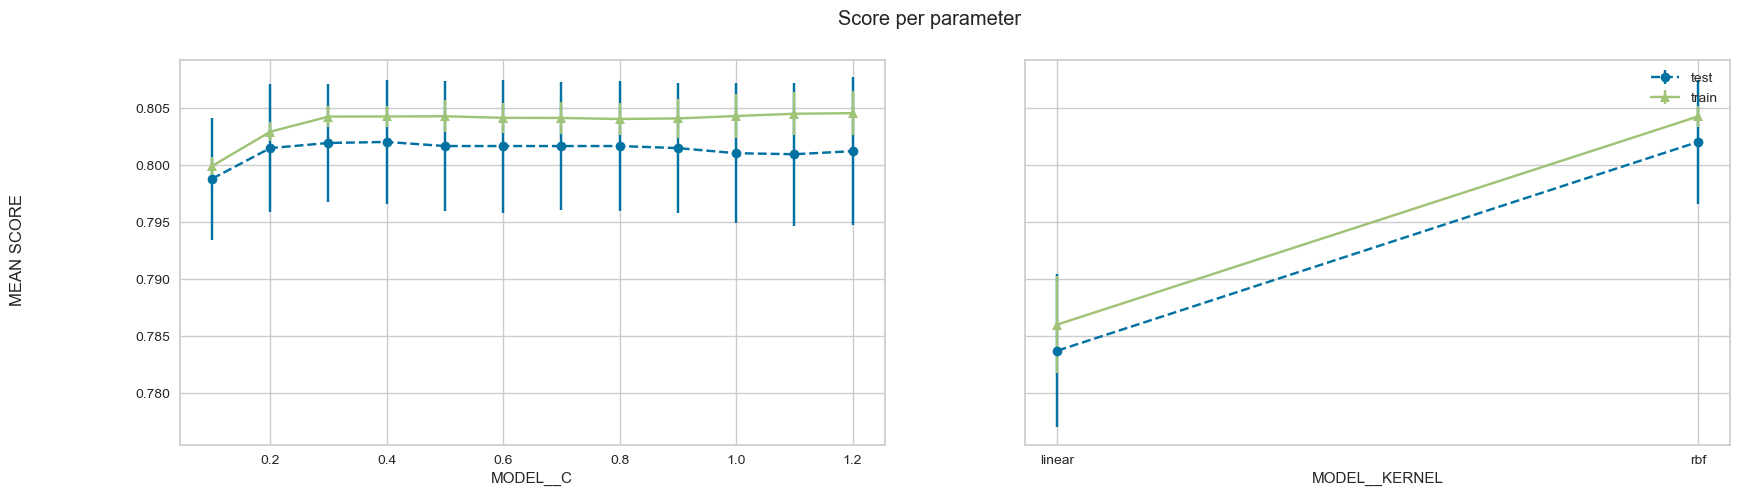

In [32]:
plot_search_results(grid_search)

Naive Bayes
Best score: 0.650725378589658
Best alpha: {'classifier__alpha': 0.0, 'classifier__fit_prior': True}


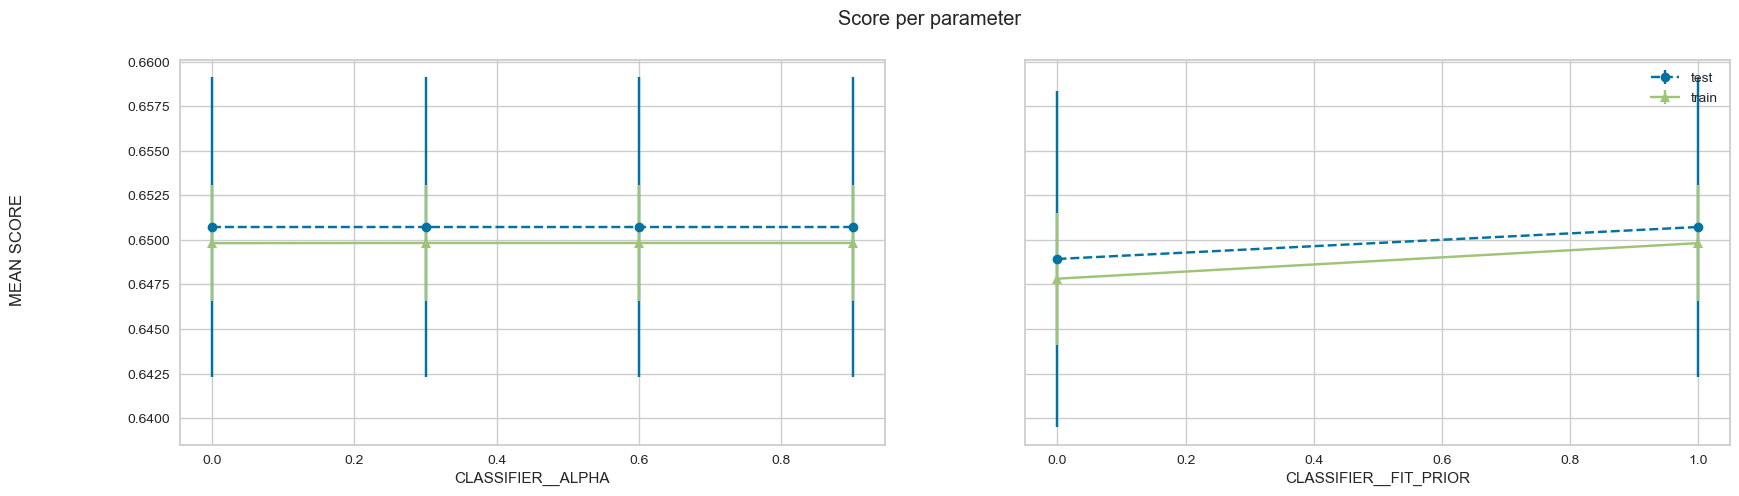

MLP
Best score: 0.8342897166917584
Best alpha: {'classifier__activation': 'logistic', 'classifier__alpha': 0.0001, 'classifier__max_iter': 200, 'classifier__solver': 'adam'}


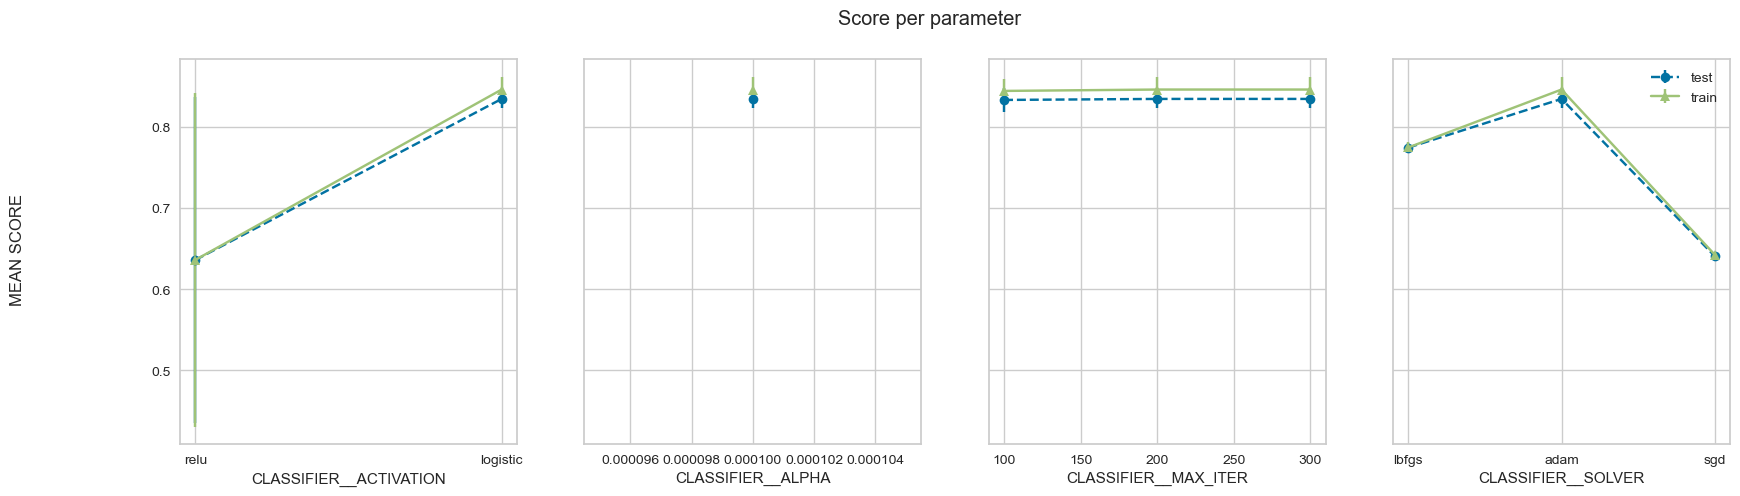

SVM


In [313]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

rs = {'random_state': 42}

log_reg = LogisticRegression(**rs)
nb = MultinomialNB()
knn = KNeighborsClassifier()
svm = SVC(**rs)
mlp = MLPClassifier(max_iter=500, **rs)
dt = DecisionTreeClassifier(**rs)
et = ExtraTreesClassifier(**rs)
rf = RandomForestClassifier(**rs)
# lgbm = LGBMClassifier(**rs, force_row_wise=True, verbosity=-1)

log_reg_params = {'C': [0.1, 1, 10]}

mlp_params = {
    'activation': ["relu", "logistic"],
    'solver': ["lbfgs", "adam", "sgd"],
    'max_iter': np.arange(100, 400, 100),
    # 'alpha': np.arange(0.0001, 0.001, 0.001)
}

knn_params = {
    'n_neighbors': list(range(1, 30)),
    'weights': ["uniform", "distance"]
}

lgbm_params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 8],
    'reg_lambda': [0, 1, 10],
}

svm_params = {
    'C': 100,
    'kernel': ['linear', 'rbf']
}

rf_params = {
    'n_estimators': np.arange(10, 150, 10),
    'class_weight': [None]
}

nb_params = {
    'alpha': np.arange(0, 1, 0.3),
    'fit_prior': [False, True]
}

clfs = [
    # ('Logistic Regression', log_reg, log_reg_params), 
    ('Naive Bayes', nb, nb_params),
    ('MLP', mlp, mlp_params),
    # ('LGBM', lgbm, lgbm_params),
    ('SVM', svm, svm_params),
    ('KNN', knn, knn_params),
    ('RF', rf, rf_params),

]
for clf_name, clf, param_grid in clfs:
    model_pipeline = Pipeline(steps=[
        ('preprocess', full_processor),
        ('classifier', clf)
    ])
    # pipeline = Pipeline(model_pipeline, param_grid, 
    #                   cv=10,
    #                   scoring='accuracy',
    #                   return_train_score=True
    # )
    print(clf_name)
    search = GridSearchCV(model_pipeline, {f'classifier__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()}, cv=10, scoring='accuracy', return_train_score=True)
    search.fit(X_train, y_train)
    print('Best score:', abs(search.best_score_))
    print('Best alpha:', search.best_params_)
    plot_search_results(search)